# CNN Architectures

In [1]:
import pandas as pd
import numpy as np
import librosa
import torch
import copy
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

In [2]:
class SpectrogramCNN(nn.Module):   
    def __init__(self):
        super(SpectrogramCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5)),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*14*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [3]:
class ChromagramCNN(nn.Module):   
    def __init__(self):
        super(ChromagramCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5), padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*12*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [4]:
class MfccCNN(nn.Module):   
    def __init__(self):
        super(MfccCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5), padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=(1,0)),
            nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*20*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [5]:
class FourierCNN(nn.Module):   
    def __init__(self):
        super(FourierCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,5)),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )
        
        
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64*22*51, out_features=2)
        )

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [6]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/Extracted data')
pickled_model = pickle.load(open('knn.pkl', 'rb'))

In [7]:
def extract_percentage_feature(filename):
    # Params
    spectrogram_list = []
    chromagram_list = []
    mfcc_list = []
    tempogram_fourier = []

    segment_length = 5 # Snippets in each track considered
    # rp% of the spectral energy lies below the value of spectral rolloff
    roll_percent = 0.85
    sr = 44100 # Sampling rate - 22 kHz
    #filename = "/Users/sainikhil/Downloads/Machine Learning/Project 2/cap6610fa22_test_set/Not_Progressive_Rock/01 Dance Yrself Clean.mp3"

    x , sr = librosa.load(filename, sr=sr)

    # Print track and genre
    #print("Done")

    # compute number of 30sec audio segments
    num_segments = int(len(x)/(sr*segment_length))


    # Create segment list
    segments = np.arange(4,num_segments-4,1,dtype=int)

    for segment in segments:
        x, sr = librosa.load(filename, sr=sr, offset=segment_length*segment, duration=segment_length)


        #Spectrogram
        melspectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_fft=4096)
        log_mel_spectrogram = librosa.power_to_db(melspectrogram)
        spectrogram_list.append(log_mel_spectrogram)

        #Chromagram
        chromagram = librosa.feature.chroma_stft(y=x, sr=sr, S=None, n_fft=2048,
                                                    hop_length=512, win_length=None, window='hann', center=True,
                                                    pad_mode='constant', tuning=None, n_chroma=12)
        chromagram_list.append(chromagram)

        # mfccs
        mfccs = librosa.feature.mfcc(y=x, sr=sr)
        mfcc_list.append(mfccs)


        # Fourier tempogram
        oenv = librosa.onset.onset_strength(y=x, sr=sr)
        fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr)
        tempogram_fourier.append(fourier_tempogram)

    spectrogram_array = np.array(spectrogram_list,dtype=np.float32)
    chromagram_array = np.array(chromagram_list,dtype=np.float32)
    mfcc_array = np.array(mfcc_list,dtype=np.float32)
    tempogram_fourier_array = np.array(tempogram_fourier,dtype=np.float32)
    print(spectrogram_array)
    
    
    output_test_fc1 = []
    device = "cpu"
    saved_model_path = '/Users/sainikhil/Downloads/Machine Learning/Project 2/Extracted data/'

    # Saving output of fully connected layer of Spectrogram
    loaded_model_spectrogram = SpectrogramCNN()
    state_dict = torch.load(saved_model_path+'spectrogram.pth')['state_dict']
    loaded_model_spectrogram.load_state_dict(state_dict)
    loaded_model_spectrogram.to(device)
    loaded_model_spectrogram.fc1.register_forward_hook(get_activation('fc1'))


    with torch.no_grad():
        x_dim = 128
        y_dim = 431
        images = spectrogram_array
        #print(images)
        images = torch.tensor(images)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        train = train.to(device)
        outputs = loaded_model_spectrogram(train)
        output_test_fc1.append(activation["fc1"])


    # Saving output of fully connected layer of Chromagram
    loaded_model_chromagram = ChromagramCNN()
    state_dict = torch.load(saved_model_path+'chromagram.pth')['state_dict']
    loaded_model_chromagram.load_state_dict(state_dict)
    loaded_model_chromagram.to(device)
    loaded_model_chromagram.fc1.register_forward_hook(get_activation('fc1'))


    with torch.no_grad():
        x_dim = 12
        y_dim = 431
        images = chromagram_array
        images = torch.tensor(images)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        train = train.to(device)
        outputs = loaded_model_chromagram(train)
        output_test_fc1.append(activation["fc1"])

    # Saving output of fully connected layer of MFCC
    loaded_model_mfcc = MfccCNN()
    state_dict = torch.load(saved_model_path+'mfcc.pth')['state_dict']
    loaded_model_mfcc.load_state_dict(state_dict)
    loaded_model_mfcc.to(device)
    loaded_model_mfcc.fc1.register_forward_hook(get_activation('fc1'))


    with torch.no_grad():
        x_dim = 20
        y_dim = 431
        images = mfcc_array
        images = torch.tensor(images)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        train = train.to(device)
        outputs = loaded_model_mfcc(train)
        output_test_fc1.append(activation["fc1"])

    # Saving output of fully connected layer of Fourier Tempogram
    #device='cpu'
    loaded_model_fourier_tempogram = FourierCNN()
    state_dict = torch.load(saved_model_path+'fourier_tempogram.pth')['state_dict']
    loaded_model_fourier_tempogram.load_state_dict(state_dict)
    loaded_model_fourier_tempogram.to(device)
    loaded_model_fourier_tempogram.fc1.register_forward_hook(get_activation('fc1'))


    with torch.no_grad():
        x_dim = 193
        y_dim = 432
        images = tempogram_fourier_array
        images = torch.tensor(images)
        train = images.view(images.shape[0], 1, x_dim, y_dim)
        train2 = torch.tensor(train,dtype=torch.float32)
        train2 = train2.to(device)
        outputs = loaded_model_fourier_tempogram(train2)
        output_test_fc1.append(activation["fc1"])
    
    output_test_fc1= tuple(output_test_fc1)
    output_array = np.array(torch.concat(output_test_fc1,dim=1).cpu())
    
    zeroes = 0
    ones = 0
    pred_array = pickled_model.predict(output_array)
    for i in range(len(pred_array)):
        if pred_array[i] == 0:
            zeroes+=1
        else:
            ones+=1
#     zeroes = np.unique(pickled_model.predict(output_array),return_counts=True)[1][0]
#     ones = np.unique(pickled_model.predict(output_array),return_counts=True)[1][1]
    zero_percentage = (zeroes/(ones+zeroes))*100
    return zero_percentage

In [8]:
feature = []
true_label = []
song_name = []

In [9]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/cap6610fa22_test_set/Progressive Rock Songs')

In [ ]:
for filename in os.listdir('.'):
    try:
        print(filename)
        feature.append(extract_percentage_feature(filename))
        true_label.append(1)
        song_name.append(filename)
        print('ok')
    except:
        print('not ok')
        pass

In [13]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/cap6610fa22_test_set/Not_Progressive_Rock')

In [ ]:
for filename in os.listdir('.'):
    try:
        print(filename)
        feature.append(extract_percentage_feature(filename))
        true_label.append(0)
        song_name.append(filename)
        print('ok')
    except:
        print('not ok')
        pass

In [20]:
np.save('correct_zerofeature_test.npy',np.array(feature))
np.save('correct_feature_test_labels.npy',np.array(true_label))
np.save('correct_feature_test_songs.npy',np.array(song_name))

# Predictions on test songs excluding other songs

In [29]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/Extracted data')
pickled_model = pickle.load(open('decision_tree_version2.pkl', 'rb'))

Results excluding post prog rock songs
Accuracy achieved on Test dataset is 0.7192118226600985
Accuracy achieved on Prog rock songs is 0.7777777777777778
Accuracy achieved on Non-prog rock songs is 0.6526315789473685


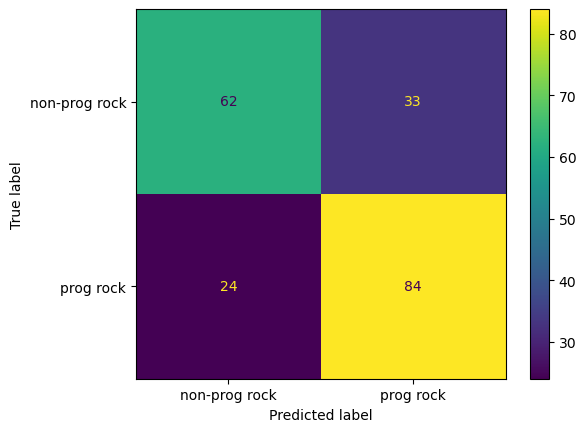

In [30]:
print("Results excluding post prog rock songs")

pred_label = []
for i in range(len(feature)):
    pred_label.append(pickled_model.predict(np.array(feature[i]).reshape(-1,1))[0])
count = 0
for i in range(len(true_label)):
    if true_label[i]==pred_label[i]:
        count+=1
print("Accuracy achieved on Test dataset is {}".format(count/len(feature)))
prog_correct = 0
total_prog = 108
for i in range(108):
    if true_label[i] == pred_label[i]:
        prog_correct+=1
print("Accuracy achieved on Prog rock songs is {}".format(prog_correct/total_prog))
non_prog_correct = 0
total_non_prog = 95
for i in range(108,len(feature)):
    if true_label[i] == pred_label[i]:
        non_prog_correct+=1
print("Accuracy achieved on Non-prog rock songs is {}".format(non_prog_correct/total_non_prog))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(np.array(true_label),np.array(pred_label)),display_labels=np.array(['non-prog rock','prog rock']))
cm_display.plot()
plt.show()

In [40]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/Extracted data')
pickled_model = pickle.load(open('knn.pkl', 'rb'))

In [41]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/cap6610fa22_test_set/Other')

In [ ]:
for filename in os.listdir('.'):
    try:
        print(filename)
        feature.append(extract_percentage_feature(filename))
        true_label.append(0)
        song_name.append(filename)
        print('ok')
    except:
        print('not ok')
        pass

# Predictions on all test songs including other songs

Results on all songs
Accuracy achieved on Test dataset is 0.672645739910314
Accuracy achieved on Prog rock songs is 0.7777777777777778
Accuracy achieved on Non-prog rock songs is 0.5739130434782609


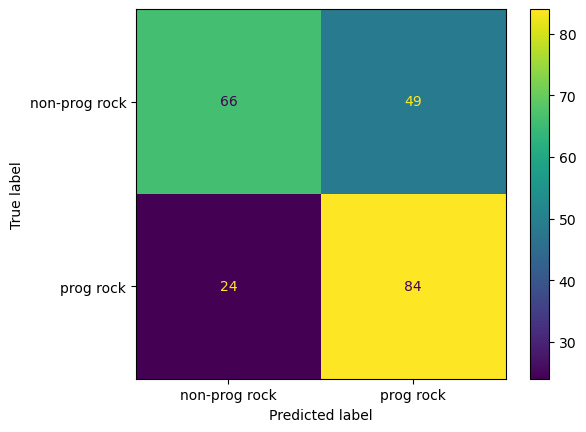

In [46]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/Extracted data')
pickled_model = pickle.load(open('decision_tree_version2.pkl', 'rb'))
print("Results on all songs")

pred_label = []
for i in range(len(feature)):
    pred_label.append(pickled_model.predict(np.array(feature[i]).reshape(-1,1))[0])
count = 0
for i in range(len(true_label)):
    if true_label[i]==pred_label[i]:
        count+=1
print("Accuracy achieved on Test dataset is {}".format(count/len(feature)))
prog_correct = 0
total_prog = 108
for i in range(108):
    if true_label[i] == pred_label[i]:
        prog_correct+=1
print("Accuracy achieved on Prog rock songs is {}".format(prog_correct/total_prog))
non_prog_correct = 0
total_non_prog = 115
for i in range(108,len(feature)):
    if true_label[i] == pred_label[i]:
        non_prog_correct+=1
print("Accuracy achieved on Non-prog rock songs is {}".format(non_prog_correct/total_non_prog))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(np.array(true_label),np.array(pred_label)),display_labels=np.array(['non-prog rock','prog rock']))
cm_display.plot()
plt.show()

# Predictions on other songs (post-prog rock set)

Results on post prog songs
Accuracy achieved on Non-prog rock songs is 0.22727272727272727


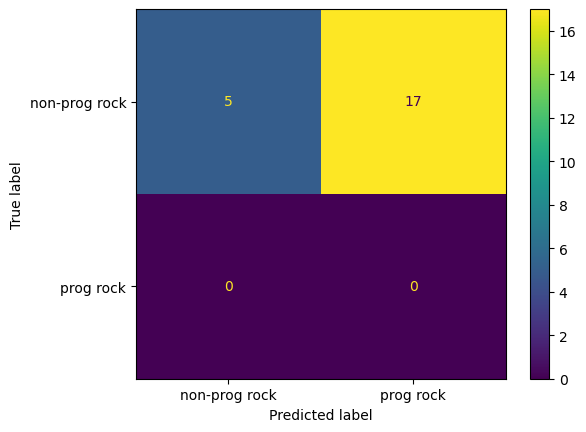

In [48]:
os.chdir('/Users/sainikhil/Downloads/Machine Learning/Project 2/Extracted data')
pickled_model = pickle.load(open('decision_tree_version2.pkl', 'rb'))
print("Results on post prog songs")

pred_label = []
for i in range(201,len(feature)):
    pred_label.append(pickled_model.predict(np.array(feature[i]).reshape(-1,1))[0])
post_prog_correct = 0
total_post_prog = 22
for i in range(201,len(feature)):
    if true_label[i] == pred_label[i-201]:
        post_prog_correct+=1
print("Accuracy achieved on Non-prog rock songs is {}".format(post_prog_correct/total_post_prog))
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(np.array(true_label[201:]),np.array(pred_label)),display_labels=np.array(['non-prog rock','prog rock']))
cm_display.plot()
plt.show()